In [43]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import DBSCAN
#from model import SimCLRModel
#from mlp import MLP
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else (torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
class GwakDataset(Dataset):
    def __init__(self, 
                 path='/n/holystore01/LABS/iaifi_lab/Lab/phlab-neurips25/GWAK/', 
                 normalize=False):
        background = self.fill_data(path+'/background.npz', normalize=normalize, label=0)
        bbh = self.fill_data(path+'bbh_for_challenge.npy', normalize=normalize, label=1)
        sglf = self.fill_data(path+'sglf_for_challenge.npy', normalize=normalize, label=2)
        self.data = np.concatenate([background[0], bbh[0], sglf[0]], axis=0)
        self.labels = np.concatenate([background[1], bbh[1], sglf[1]], axis=0)

    def fill_data(self, path, normalize=True, label=0):
        if path.endswith('npz'):
            data = np.load(path)['data']
        else:
            data = np.load(path)
        if normalize:
            stds = np.std(data, axis=-1)[:, :, np.newaxis]
            data = data/stds
        #data = np.swapaxes(data, 1, 2)
        data = np.float32(data)
        target = np.full(data.shape[0], label)
        return data, target
    
    def generate_augmentation(self,batch):
        return None
    
    def normalize(self,batch):
        return (batch - self.mean.to(batch)) / self.std.to(batch)

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self,idx):
        return self.data[idx, :, :], self.labels[idx]

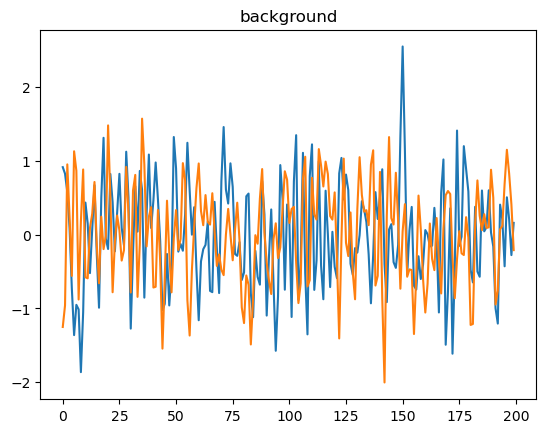

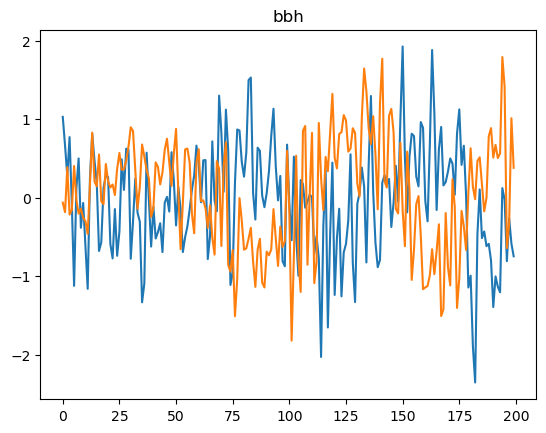

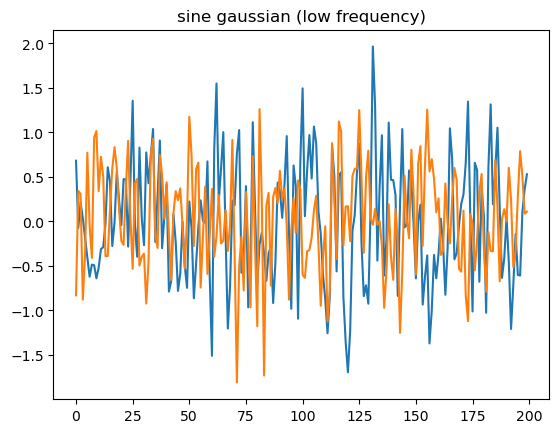

In [45]:
dset = GwakDataset()
generator = torch.Generator().manual_seed(42)
trainset, testset = torch.utils.data.random_split(dset, [0.8,0.2], generator=generator)

data = dset.data
labels = dset.labels

# plot time series for each dataset
for i in range(3):
    if i ==0:
        text='background'
    elif i ==1:
        text='bbh'
    elif i==2:
        text='sine gaussian (low frequency)'
    selc = data[labels==i][0]
    times = np.arange(selc.shape[1])
    fig = plt.figure()

    plt.plot(times, selc[0,:])
    plt.plot(times, selc[1,:])
    plt.title(text)
    fig.show()

  1%|          | 1/100 [00:26<44:24, 26.91s/it]

Epoch [1/100], Loss: 4.2741


  2%|▏         | 2/100 [00:53<43:56, 26.90s/it]

Epoch [2/100], Loss: 4.0544


  3%|▎         | 3/100 [01:20<43:32, 26.93s/it]

Epoch [3/100], Loss: 4.0367


  4%|▍         | 4/100 [01:47<43:02, 26.90s/it]

Epoch [4/100], Loss: 4.0279


  5%|▌         | 5/100 [02:14<42:36, 26.91s/it]

Epoch [5/100], Loss: 4.0243


  6%|▌         | 6/100 [02:41<42:08, 26.90s/it]

Epoch [6/100], Loss: 4.0239


  7%|▋         | 7/100 [03:08<41:39, 26.88s/it]

Epoch [7/100], Loss: 4.0204


  8%|▊         | 8/100 [03:35<41:16, 26.92s/it]

Epoch [8/100], Loss: 4.0223


  9%|▉         | 9/100 [04:02<40:47, 26.89s/it]

Epoch [9/100], Loss: 4.0178


 10%|█         | 10/100 [04:28<40:18, 26.87s/it]

Epoch [10/100], Loss: 4.0181


 11%|█         | 11/100 [04:55<39:56, 26.93s/it]

Epoch [11/100], Loss: 4.0146


 12%|█▏        | 12/100 [05:22<39:27, 26.90s/it]

Epoch [12/100], Loss: 4.0146


 13%|█▎        | 13/100 [05:49<39:01, 26.92s/it]

Epoch [13/100], Loss: 4.0144


 14%|█▍        | 14/100 [06:16<38:34, 26.91s/it]

Epoch [14/100], Loss: 4.0125


 15%|█▌        | 15/100 [06:43<38:05, 26.89s/it]

Epoch [15/100], Loss: 4.0141


 16%|█▌        | 16/100 [07:10<37:41, 26.92s/it]

Epoch [16/100], Loss: 4.0117


 17%|█▋        | 17/100 [07:37<37:12, 26.90s/it]

Epoch [17/100], Loss: 4.0113


 18%|█▊        | 18/100 [08:04<36:43, 26.87s/it]

Epoch [18/100], Loss: 4.0111


 19%|█▉        | 19/100 [08:31<36:15, 26.86s/it]

Epoch [19/100], Loss: 4.0099


 20%|██        | 20/100 [08:57<35:48, 26.86s/it]

Epoch [20/100], Loss: 4.0102


 21%|██        | 21/100 [09:24<35:20, 26.85s/it]

Epoch [21/100], Loss: 4.0097


 22%|██▏       | 22/100 [09:51<34:53, 26.84s/it]

Epoch [22/100], Loss: 4.0083


 23%|██▎       | 23/100 [10:18<34:26, 26.84s/it]

Epoch [23/100], Loss: 4.0081


 24%|██▍       | 24/100 [10:45<33:59, 26.84s/it]

Epoch [24/100], Loss: 4.0093


 25%|██▌       | 25/100 [11:12<33:32, 26.84s/it]

Epoch [25/100], Loss: 4.0069


 26%|██▌       | 26/100 [11:38<33:05, 26.84s/it]

Epoch [26/100], Loss: 4.0081


 27%|██▋       | 27/100 [12:05<32:38, 26.83s/it]

Epoch [27/100], Loss: 4.0075


 28%|██▊       | 28/100 [12:32<32:11, 26.83s/it]

Epoch [28/100], Loss: 4.0071


 29%|██▉       | 29/100 [12:59<31:45, 26.84s/it]

Epoch [29/100], Loss: 4.0070


 30%|███       | 30/100 [13:26<31:18, 26.84s/it]

Epoch [30/100], Loss: 4.0067


 31%|███       | 31/100 [13:53<30:51, 26.84s/it]

Epoch [31/100], Loss: 4.0068


 32%|███▏      | 32/100 [14:19<30:24, 26.84s/it]

Epoch [32/100], Loss: 4.0050


 33%|███▎      | 33/100 [14:46<29:58, 26.85s/it]

Epoch [33/100], Loss: 4.0062


 34%|███▍      | 34/100 [15:13<29:32, 26.85s/it]

Epoch [34/100], Loss: 4.0057


 35%|███▌      | 35/100 [15:40<29:05, 26.85s/it]

Epoch [35/100], Loss: 4.0056


 36%|███▌      | 36/100 [16:07<28:38, 26.84s/it]

Epoch [36/100], Loss: 4.0056


 37%|███▋      | 37/100 [16:34<28:10, 26.84s/it]

Epoch [37/100], Loss: 4.0048


 38%|███▊      | 38/100 [17:00<27:43, 26.83s/it]

Epoch [38/100], Loss: 4.0048


 39%|███▉      | 39/100 [17:27<27:18, 26.87s/it]

Epoch [39/100], Loss: 4.0063


 40%|████      | 40/100 [17:54<26:52, 26.87s/it]

Epoch [40/100], Loss: 4.0057


 41%|████      | 41/100 [18:21<26:26, 26.89s/it]

Epoch [41/100], Loss: 4.0053


 42%|████▏     | 42/100 [18:48<26:02, 26.94s/it]

Epoch [42/100], Loss: 4.0039


 43%|████▎     | 43/100 [19:15<25:33, 26.90s/it]

Epoch [43/100], Loss: 4.0043


 44%|████▍     | 44/100 [19:42<25:04, 26.87s/it]

Epoch [44/100], Loss: 4.0060


 45%|████▌     | 45/100 [20:09<24:40, 26.92s/it]

Epoch [45/100], Loss: 4.0040


 46%|████▌     | 46/100 [20:36<24:11, 26.89s/it]

Epoch [46/100], Loss: 4.0045


 47%|████▋     | 47/100 [21:03<23:46, 26.91s/it]

Epoch [47/100], Loss: 4.0034


 48%|████▊     | 48/100 [21:30<23:18, 26.90s/it]

Epoch [48/100], Loss: 4.0044


 49%|████▉     | 49/100 [21:56<22:50, 26.87s/it]

Epoch [49/100], Loss: 4.0046


 50%|█████     | 50/100 [22:23<22:25, 26.92s/it]

Epoch [50/100], Loss: 4.0027


 51%|█████     | 51/100 [22:50<21:58, 26.90s/it]

Epoch [51/100], Loss: 4.0045


 52%|█████▏    | 52/100 [23:17<21:30, 26.88s/it]

Epoch [52/100], Loss: 4.0034


 53%|█████▎    | 53/100 [23:44<21:05, 26.92s/it]

Epoch [53/100], Loss: 4.0037


 54%|█████▍    | 54/100 [24:11<20:37, 26.89s/it]

Epoch [54/100], Loss: 4.0042


 55%|█████▌    | 55/100 [24:38<20:10, 26.90s/it]

Epoch [55/100], Loss: 4.0031


 56%|█████▌    | 56/100 [25:05<19:44, 26.92s/it]

Epoch [56/100], Loss: 4.0035


 57%|█████▋    | 57/100 [25:32<19:16, 26.89s/it]

Epoch [57/100], Loss: 4.0031


 58%|█████▊    | 58/100 [25:58<18:48, 26.88s/it]

Epoch [58/100], Loss: 4.0033


 59%|█████▉    | 59/100 [26:25<18:21, 26.87s/it]

Epoch [59/100], Loss: 4.0035


 60%|██████    | 60/100 [26:52<17:54, 26.86s/it]

Epoch [60/100], Loss: 4.0037


 61%|██████    | 61/100 [27:19<17:27, 26.86s/it]

Epoch [61/100], Loss: 4.0026


 62%|██████▏   | 62/100 [27:46<17:00, 26.85s/it]

Epoch [62/100], Loss: 4.0030


 63%|██████▎   | 63/100 [28:13<16:33, 26.84s/it]

Epoch [63/100], Loss: 4.0025


 64%|██████▍   | 64/100 [28:40<16:06, 26.84s/it]

Epoch [64/100], Loss: 4.0033


 65%|██████▌   | 65/100 [29:06<15:39, 26.85s/it]

Epoch [65/100], Loss: 4.0024


 66%|██████▌   | 66/100 [29:33<15:12, 26.85s/it]

Epoch [66/100], Loss: 4.0033


 67%|██████▋   | 67/100 [30:00<14:45, 26.84s/it]

Epoch [67/100], Loss: 4.0027


 68%|██████▊   | 68/100 [30:27<14:19, 26.84s/it]

Epoch [68/100], Loss: 4.0026


 69%|██████▉   | 69/100 [30:54<13:52, 26.85s/it]

Epoch [69/100], Loss: 4.0031


 70%|███████   | 70/100 [31:21<13:25, 26.86s/it]

Epoch [70/100], Loss: 4.0022


 71%|███████   | 71/100 [31:47<12:58, 26.84s/it]

Epoch [71/100], Loss: 4.0025


 72%|███████▏  | 72/100 [32:14<12:31, 26.84s/it]

Epoch [72/100], Loss: 4.0029


 73%|███████▎  | 73/100 [32:41<12:04, 26.83s/it]

Epoch [73/100], Loss: 4.0026


 74%|███████▍  | 74/100 [33:08<11:37, 26.83s/it]

Epoch [74/100], Loss: 4.0027


 75%|███████▌  | 75/100 [33:35<11:10, 26.83s/it]

Epoch [75/100], Loss: 4.0026


 76%|███████▌  | 76/100 [34:02<10:43, 26.83s/it]

Epoch [76/100], Loss: 4.0027


 77%|███████▋  | 77/100 [34:28<10:17, 26.83s/it]

Epoch [77/100], Loss: 4.0015


 78%|███████▊  | 78/100 [34:55<09:50, 26.83s/it]

Epoch [78/100], Loss: 4.0014


 79%|███████▉  | 79/100 [35:22<09:23, 26.85s/it]

Epoch [79/100], Loss: 4.0008


 80%|████████  | 80/100 [35:49<08:56, 26.84s/it]

Epoch [80/100], Loss: 4.0010


 81%|████████  | 81/100 [36:16<08:29, 26.84s/it]

Epoch [81/100], Loss: 4.0009


 82%|████████▏ | 82/100 [36:43<08:02, 26.83s/it]

Epoch [82/100], Loss: 4.0012


 83%|████████▎ | 83/100 [37:09<07:36, 26.84s/it]

Epoch [83/100], Loss: 4.0012


 84%|████████▍ | 84/100 [37:36<07:09, 26.83s/it]

Epoch [84/100], Loss: 4.0004


 85%|████████▌ | 85/100 [38:03<06:42, 26.83s/it]

Epoch [85/100], Loss: 4.0009


 86%|████████▌ | 86/100 [38:30<06:15, 26.83s/it]

Epoch [86/100], Loss: 4.0012


 87%|████████▋ | 87/100 [38:57<05:48, 26.83s/it]

Epoch [87/100], Loss: 4.0003


 88%|████████▊ | 88/100 [39:24<05:22, 26.84s/it]

Epoch [88/100], Loss: 4.0001


 89%|████████▉ | 89/100 [39:50<04:55, 26.83s/it]

Epoch [89/100], Loss: 3.9999


 90%|█████████ | 90/100 [40:17<04:28, 26.83s/it]

Epoch [90/100], Loss: 4.0000


 91%|█████████ | 91/100 [40:44<04:01, 26.83s/it]

Epoch [91/100], Loss: 4.0000


 92%|█████████▏| 92/100 [41:11<03:34, 26.84s/it]

Epoch [92/100], Loss: 4.0002


 93%|█████████▎| 93/100 [41:38<03:07, 26.83s/it]

Epoch [93/100], Loss: 4.0032


 94%|█████████▍| 94/100 [42:05<02:40, 26.83s/it]

Epoch [94/100], Loss: 4.0015


 95%|█████████▌| 95/100 [42:31<02:14, 26.83s/it]

Epoch [95/100], Loss: 4.0014


 96%|█████████▌| 96/100 [42:58<01:47, 26.83s/it]

Epoch [96/100], Loss: 4.0004


 97%|█████████▋| 97/100 [43:25<01:20, 26.84s/it]

Epoch [97/100], Loss: 4.0005


 98%|█████████▊| 98/100 [43:52<00:53, 26.84s/it]

Epoch [98/100], Loss: 4.0011


 99%|█████████▉| 99/100 [44:19<00:26, 26.83s/it]

Epoch [99/100], Loss: 4.0006


100%|██████████| 100/100 [44:46<00:00, 26.86s/it]

Epoch [100/100], Loss: 4.0007


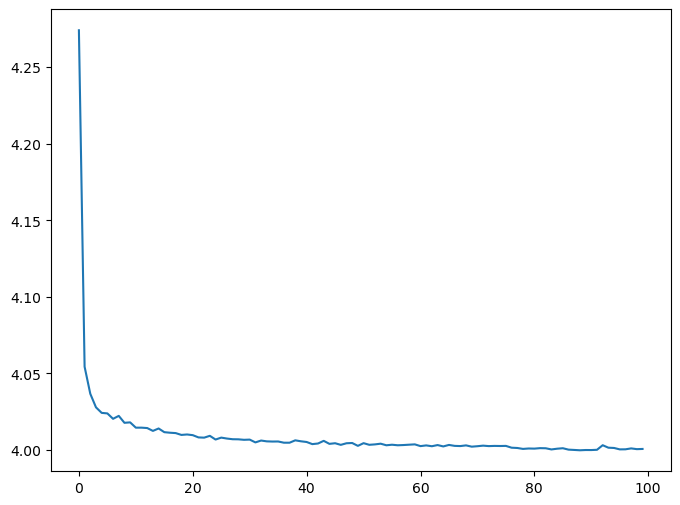

In [49]:
import sys
sys.path.append('../../')

from models.losses import SupervisedSimCLRLoss
from models.networks import MLP
from models.litmodels import SimCLRModel
from models.resnet_1d import ResNet1D
from tqdm import tqdm

temp = 0.05
criterion = SupervisedSimCLRLoss(temperature=temp)

# Define a dummy CNN model
embed_dim = 8
embedder = ResNet1D(in_channels=2, layers=[3, 4, 6, 3], classes=embed_dim).to(device)
projector = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim).to(device)
model = SimCLRModel(embedder, projector).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-3)

# Training loop
num_epochs = 100
batch_size = 350
# Dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = []
    for batch_data, labels in dataloader:
        batch_data = batch_data.float().to(device)

        # Potential to add any augmentation here
        features = model(batch_data).unsqueeze(1)
        
        # Compute SimCLR loss
        loss = criterion(features,labels=labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    losses.append(mean_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {mean_loss:.4f}')
    

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses)),losses)

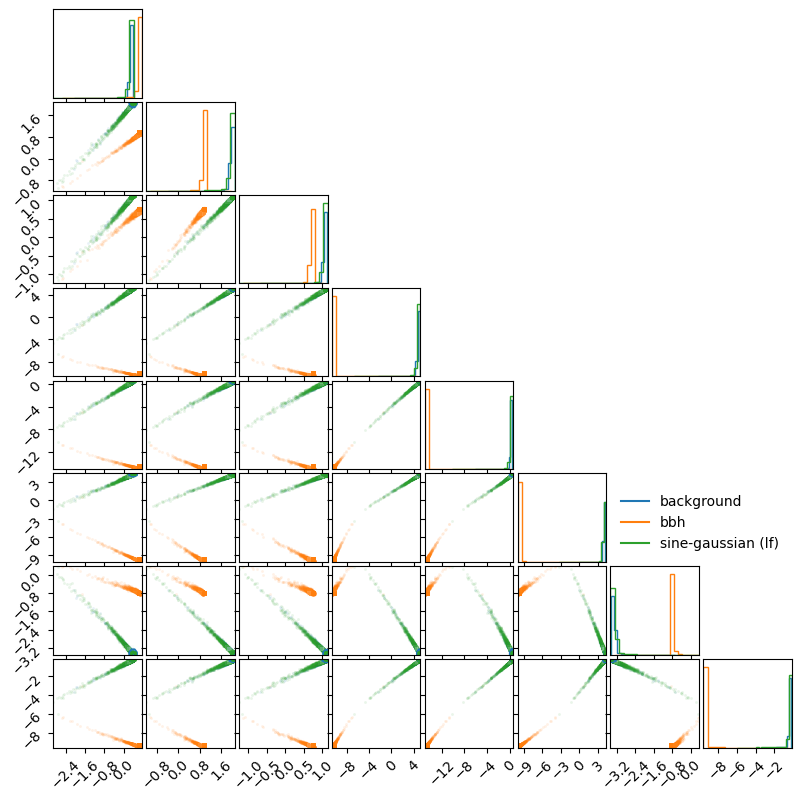

In [63]:
#data = testset[:][0].float()
#labels = testset[:][1].numpy()
data = torch.from_numpy(testset[:][0])
labels = testset[:][1]
with torch.no_grad():
    output = []
    for sp in torch.split(data,10000):
        #sp = testset.normalize(sp)
        output.append(model(sp.to(device),embed=True).cpu().numpy())
    output = np.concatenate(output,axis=0)

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0],fig=fig,color="C0", label='background')
corner.corner(output[labels==1],fig=fig,color="C1", label='bbh')
corner.corner(output[labels==2],fig=fig,color="C2", label='sine-gaussian (lf)')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C1", label='bbh'),
            mlines.Line2D([], [], color="C2", label='sine-gaussian (lf)')
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()

In [56]:
output[labels==0]

array([[ 0.30393746,  1.9883635 ,  1.0723886 , ...,  4.0160036 ,
        -3.3680298 , -0.37040728],
       [ 0.37220517,  2.0394506 ,  1.11181   , ...,  4.120567  ,
        -3.4192326 , -0.26176667],
       [ 0.27686045,  1.9552408 ,  1.0520155 , ...,  3.948271  ,
        -3.3053024 , -0.3988024 ],
       ...,
       [ 0.3626772 ,  2.0310507 ,  1.1060886 , ...,  4.0702834 ,
        -3.3912687 , -0.30698454],
       [ 0.27162474,  1.9249507 ,  1.0240341 , ...,  3.888367  ,
        -3.2670717 , -0.44405377],
       [ 0.3277228 ,  2.00565   ,  1.0809418 , ...,  4.0021596 ,
        -3.3626776 , -0.35228217]], shape=(20041, 8), dtype=float32)